# Dissecting Spotify Valence
---

> *Name:* Panagiota Gkourioti <br />
> *Student ID:* p2822109 <br />
> *Course:* Business Analytics Practicum I <br />
> *Professor:* Panos Louridas <br />

> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />

## Description of the case

The objective of this notebook is to untangle the mystery behind Spotify's valence metric and propose how this is derived. Spotify uses this metric to measure the happiness of a track. “Valence” is used to describe whether something is likely to make someone feel happy (positive valence) or sad (negative valence). Our reaction to music is also emotional. Some of it makes us happy, and some of it makes us sad, with songs falling all across the spectrum between happy and sad.

The metric was originally developed by Echo Nest, a company that was bought by Spotify in 2014. At The Echo Nest, audio is analyzed in all sorts of ways as part of our deep music intelligence. 


## Load the necessary libraries

Initially, the necessary libraries that will be used in the first part of this project are imported. 

In [7]:
import pandas as pd
import numpy as np

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotify_config import config

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Obtain and Read Data 

Data acquisition is a crucial part of the analysis. We will use two sources to obtain the data:

* [Spotify's Web API](https://developer.spotify.com/documentation/web-api/): Spotify offers numerous metrics for every song through its API. For this project, we use [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).


* A dataset from *Kaggle* (https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db) which contains 232,725 tracks, in order to obtain a big sample of songs and their ids on Spotify.


Firstly, we read the dataset from *Kaggle*, keeping only songs' ids and names, because the features will be extracted from Spotify's Web API.

In [8]:
tracks = pd.read_csv('data/SpotifyFeatures.csv', usecols=['track_id', 'track_name'])
tracks

,track_name,track_id
0,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV
1,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP
2,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy
3,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf
4,Ouverture,0IuslXpMROHdEPvSl1fTQK
...,...,...
232720,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT
232721,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM
232722,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t
232723,With My Words,6EFsue2YbIG4Qkq8Zr9Rir


* We want to keep only the unique ids from the dataset and also confirm that there are no duplicate songs having different ids.

In [9]:
tracks.drop_duplicates(subset='track_id', inplace=True)
tracks.drop_duplicates(subset='track_name', inplace=True)
len(tracks['track_id'])

148400

#### Spotify API
The next step is to obtain each track's audio feature and analysis, therefore we need to set up our Spotify API, using [Spotify for Developers](https://developer.spotify.com/).

* For storing our credentials, we will create a file `spotify_config.py` with the following contents:

In [10]:
config = {
    'client_id' : '0e66c1c659674e19b37a0a1d812d8727',
    'client_secret' :'173106115a3740e4a5af5827805e7108'
}

* Afterwards, we can create a Spotify client.

In [11]:
client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* We want to get, for each of the top-streaming tracks, its [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features).

* To do that, we will create two dictionaries keyed by `track_id`, with values being the audio features for the specific track and some extra features.

In [12]:
features = {}
extra_features = {}
all_track_ids = list(tracks['track_id'].unique())

* The call for getting several audio features can get no more than 100 at a time, therefore we will have to iterate.

In [13]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

getting from 30100 to 30200
getting from 30200 to 30300
getting from 30300 to 30400
getting from 30400 to 30500
getting from 30500 to 30600
getting from 30600 to 30700
getting from 30700 to 30800
getting from 30800 to 30900
getting from 30900 to 31000
getting from 31000 to 31100
getting from 31100 to 31200
getting from 31200 to 31300
getting from 31300 to 31400
getting from 31400 to 31500
getting from 31500 to 31600
getting from 31600 to 31700
getting from 31700 to 31800
getting from 31800 to 31900
getting from 31900 to 32000
getting from 32000 to 32100
getting from 32100 to 32200
getting from 32200 to 32300
getting from 32300 to 32400
getting from 32400 to 32500
getting from 32500 to 32600
getting from 32600 to 32700
getting from 32700 to 32800
getting from 32800 to 32900
getting from 32900 to 33000
getting from 33000 to 33100
getting from 33100 to 33200
getting from 33200 to 33300
getting from 33300 to 33400
getting from 33400 to 33500
getting from 33500 to 33600
getting from 33600 t

getting from 59500 to 59600
getting from 59600 to 59700
getting from 59700 to 59800
getting from 59800 to 59900
getting from 59900 to 60000
getting from 60000 to 60100
getting from 60100 to 60200
getting from 60200 to 60300
getting from 60300 to 60400
getting from 60400 to 60500
getting from 60500 to 60600
getting from 60600 to 60700
getting from 60700 to 60800
getting from 60800 to 60900
getting from 60900 to 61000
getting from 61000 to 61100
getting from 61100 to 61200
getting from 61200 to 61300
getting from 61300 to 61400
getting from 61400 to 61500
getting from 61500 to 61600
getting from 61600 to 61700
getting from 61700 to 61800
getting from 61800 to 61900
getting from 61900 to 62000
getting from 62000 to 62100
getting from 62100 to 62200
getting from 62200 to 62300
getting from 62300 to 62400
getting from 62400 to 62500
getting from 62500 to 62600
getting from 62600 to 62700
getting from 62700 to 62800
getting from 62800 to 62900
getting from 62900 to 63000
getting from 63000 t

getting from 88900 to 89000
getting from 89000 to 89100
getting from 89100 to 89200
getting from 89200 to 89300
getting from 89300 to 89400
getting from 89400 to 89500
getting from 89500 to 89600
getting from 89600 to 89700
getting from 89700 to 89800
getting from 89800 to 89900
getting from 89900 to 90000
getting from 90000 to 90100
getting from 90100 to 90200
getting from 90200 to 90300
getting from 90300 to 90400
getting from 90400 to 90500
getting from 90500 to 90600
getting from 90600 to 90700
getting from 90700 to 90800
getting from 90800 to 90900
getting from 90900 to 91000
getting from 91000 to 91100
getting from 91100 to 91200
getting from 91200 to 91300
getting from 91300 to 91400
getting from 91400 to 91500
getting from 91500 to 91600
getting from 91600 to 91700
getting from 91700 to 91800
getting from 91800 to 91900
getting from 91900 to 92000
getting from 92000 to 92100
getting from 92100 to 92200
getting from 92200 to 92300
getting from 92300 to 92400
getting from 92400 t

getting from 117000 to 117100
getting from 117100 to 117200
getting from 117200 to 117300
getting from 117300 to 117400
getting from 117400 to 117500
getting from 117500 to 117600
getting from 117600 to 117700
getting from 117700 to 117800
getting from 117800 to 117900
getting from 117900 to 118000
getting from 118000 to 118100
getting from 118100 to 118200
getting from 118200 to 118300
getting from 118300 to 118400
getting from 118400 to 118500
getting from 118500 to 118600
getting from 118600 to 118700
getting from 118700 to 118800
getting from 118800 to 118900
getting from 118900 to 119000
getting from 119000 to 119100
getting from 119100 to 119200
getting from 119200 to 119300
getting from 119300 to 119400
getting from 119400 to 119500
getting from 119500 to 119600
getting from 119600 to 119700
getting from 119700 to 119800
getting from 119800 to 119900
getting from 119900 to 120000
getting from 120000 to 120100
getting from 120100 to 120200
getting from 120200 to 120300
getting fr

* We do the same for the extra track features, by using sp.tracks method. In this case, Spotify permits 50 ids per batch.

In [14]:
start = 0
num_tracks = 50
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.tracks(tracks_batch)
    extra_features.update({ track_id : {'explicit': features['explicit'], 'release_date': features['album']['release_date']} 
                        for track_id, features in zip(tracks_batch, features_batch['tracks']) })
    start += num_tracks

getting from 0 to 50
getting from 50 to 100
getting from 100 to 150
getting from 150 to 200
getting from 200 to 250
getting from 250 to 300
getting from 300 to 350
getting from 350 to 400
getting from 400 to 450
getting from 450 to 500
getting from 500 to 550
getting from 550 to 600
getting from 600 to 650
getting from 650 to 700
getting from 700 to 750
getting from 750 to 800
getting from 800 to 850
getting from 850 to 900
getting from 900 to 950
getting from 950 to 1000
getting from 1000 to 1050
getting from 1050 to 1100
getting from 1100 to 1150
getting from 1150 to 1200
getting from 1200 to 1250
getting from 1250 to 1300
getting from 1300 to 1350
getting from 1350 to 1400
getting from 1400 to 1450
getting from 1450 to 1500
getting from 1500 to 1550
getting from 1550 to 1600
getting from 1600 to 1650
getting from 1650 to 1700
getting from 1700 to 1750
getting from 1750 to 1800
getting from 1800 to 1850
getting from 1850 to 1900
getting from 1900 to 1950
getting from 1950 to 2000
get

getting from 15500 to 15550
getting from 15550 to 15600
getting from 15600 to 15650
getting from 15650 to 15700
getting from 15700 to 15750
getting from 15750 to 15800
getting from 15800 to 15850
getting from 15850 to 15900
getting from 15900 to 15950
getting from 15950 to 16000
getting from 16000 to 16050
getting from 16050 to 16100
getting from 16100 to 16150
getting from 16150 to 16200
getting from 16200 to 16250
getting from 16250 to 16300
getting from 16300 to 16350
getting from 16350 to 16400
getting from 16400 to 16450
getting from 16450 to 16500
getting from 16500 to 16550
getting from 16550 to 16600
getting from 16600 to 16650
getting from 16650 to 16700
getting from 16700 to 16750
getting from 16750 to 16800
getting from 16800 to 16850
getting from 16850 to 16900
getting from 16900 to 16950
getting from 16950 to 17000
getting from 17000 to 17050
getting from 17050 to 17100
getting from 17100 to 17150
getting from 17150 to 17200
getting from 17200 to 17250
getting from 17250 t

getting from 30200 to 30250
getting from 30250 to 30300
getting from 30300 to 30350
getting from 30350 to 30400
getting from 30400 to 30450
getting from 30450 to 30500
getting from 30500 to 30550
getting from 30550 to 30600
getting from 30600 to 30650
getting from 30650 to 30700
getting from 30700 to 30750
getting from 30750 to 30800
getting from 30800 to 30850
getting from 30850 to 30900
getting from 30900 to 30950
getting from 30950 to 31000
getting from 31000 to 31050
getting from 31050 to 31100
getting from 31100 to 31150
getting from 31150 to 31200
getting from 31200 to 31250
getting from 31250 to 31300
getting from 31300 to 31350
getting from 31350 to 31400
getting from 31400 to 31450
getting from 31450 to 31500
getting from 31500 to 31550
getting from 31550 to 31600
getting from 31600 to 31650
getting from 31650 to 31700
getting from 31700 to 31750
getting from 31750 to 31800
getting from 31800 to 31850
getting from 31850 to 31900
getting from 31900 to 31950
getting from 31950 t

getting from 44850 to 44900
getting from 44900 to 44950
getting from 44950 to 45000
getting from 45000 to 45050
getting from 45050 to 45100
getting from 45100 to 45150
getting from 45150 to 45200
getting from 45200 to 45250
getting from 45250 to 45300
getting from 45300 to 45350
getting from 45350 to 45400
getting from 45400 to 45450
getting from 45450 to 45500
getting from 45500 to 45550
getting from 45550 to 45600
getting from 45600 to 45650
getting from 45650 to 45700
getting from 45700 to 45750
getting from 45750 to 45800
getting from 45800 to 45850
getting from 45850 to 45900
getting from 45900 to 45950
getting from 45950 to 46000
getting from 46000 to 46050
getting from 46050 to 46100
getting from 46100 to 46150
getting from 46150 to 46200
getting from 46200 to 46250
getting from 46250 to 46300
getting from 46300 to 46350
getting from 46350 to 46400
getting from 46400 to 46450
getting from 46450 to 46500
getting from 46500 to 46550
getting from 46550 to 46600
getting from 46600 t

getting from 59550 to 59600
getting from 59600 to 59650
getting from 59650 to 59700
getting from 59700 to 59750
getting from 59750 to 59800
getting from 59800 to 59850
getting from 59850 to 59900
getting from 59900 to 59950
getting from 59950 to 60000
getting from 60000 to 60050
getting from 60050 to 60100
getting from 60100 to 60150
getting from 60150 to 60200
getting from 60200 to 60250
getting from 60250 to 60300
getting from 60300 to 60350
getting from 60350 to 60400
getting from 60400 to 60450
getting from 60450 to 60500
getting from 60500 to 60550
getting from 60550 to 60600
getting from 60600 to 60650
getting from 60650 to 60700
getting from 60700 to 60750
getting from 60750 to 60800
getting from 60800 to 60850
getting from 60850 to 60900
getting from 60900 to 60950
getting from 60950 to 61000
getting from 61000 to 61050
getting from 61050 to 61100
getting from 61100 to 61150
getting from 61150 to 61200
getting from 61200 to 61250
getting from 61250 to 61300
getting from 61300 t

getting from 74250 to 74300
getting from 74300 to 74350
getting from 74350 to 74400
getting from 74400 to 74450
getting from 74450 to 74500
getting from 74500 to 74550
getting from 74550 to 74600
getting from 74600 to 74650
getting from 74650 to 74700
getting from 74700 to 74750
getting from 74750 to 74800
getting from 74800 to 74850
getting from 74850 to 74900
getting from 74900 to 74950
getting from 74950 to 75000
getting from 75000 to 75050
getting from 75050 to 75100
getting from 75100 to 75150
getting from 75150 to 75200
getting from 75200 to 75250
getting from 75250 to 75300
getting from 75300 to 75350
getting from 75350 to 75400
getting from 75400 to 75450
getting from 75450 to 75500
getting from 75500 to 75550
getting from 75550 to 75600
getting from 75600 to 75650
getting from 75650 to 75700
getting from 75700 to 75750
getting from 75750 to 75800
getting from 75800 to 75850
getting from 75850 to 75900
getting from 75900 to 75950
getting from 75950 to 76000
getting from 76000 t

getting from 88950 to 89000
getting from 89000 to 89050
getting from 89050 to 89100
getting from 89100 to 89150
getting from 89150 to 89200
getting from 89200 to 89250
getting from 89250 to 89300
getting from 89300 to 89350
getting from 89350 to 89400
getting from 89400 to 89450
getting from 89450 to 89500
getting from 89500 to 89550
getting from 89550 to 89600
getting from 89600 to 89650
getting from 89650 to 89700
getting from 89700 to 89750
getting from 89750 to 89800
getting from 89800 to 89850
getting from 89850 to 89900
getting from 89900 to 89950
getting from 89950 to 90000
getting from 90000 to 90050
getting from 90050 to 90100
getting from 90100 to 90150
getting from 90150 to 90200
getting from 90200 to 90250
getting from 90250 to 90300
getting from 90300 to 90350
getting from 90350 to 90400
getting from 90400 to 90450
getting from 90450 to 90500
getting from 90500 to 90550
getting from 90550 to 90600
getting from 90600 to 90650
getting from 90650 to 90700
getting from 90700 t

getting from 103350 to 103400
getting from 103400 to 103450
getting from 103450 to 103500
getting from 103500 to 103550
getting from 103550 to 103600
getting from 103600 to 103650
getting from 103650 to 103700
getting from 103700 to 103750
getting from 103750 to 103800
getting from 103800 to 103850
getting from 103850 to 103900
getting from 103900 to 103950
getting from 103950 to 104000
getting from 104000 to 104050
getting from 104050 to 104100
getting from 104100 to 104150
getting from 104150 to 104200
getting from 104200 to 104250
getting from 104250 to 104300
getting from 104300 to 104350
getting from 104350 to 104400
getting from 104400 to 104450
getting from 104450 to 104500
getting from 104500 to 104550
getting from 104550 to 104600
getting from 104600 to 104650
getting from 104650 to 104700
getting from 104700 to 104750
getting from 104750 to 104800
getting from 104800 to 104850
getting from 104850 to 104900
getting from 104900 to 104950
getting from 104950 to 105000
getting fr

getting from 117050 to 117100
getting from 117100 to 117150
getting from 117150 to 117200
getting from 117200 to 117250
getting from 117250 to 117300
getting from 117300 to 117350
getting from 117350 to 117400
getting from 117400 to 117450
getting from 117450 to 117500
getting from 117500 to 117550
getting from 117550 to 117600
getting from 117600 to 117650
getting from 117650 to 117700
getting from 117700 to 117750
getting from 117750 to 117800
getting from 117800 to 117850
getting from 117850 to 117900
getting from 117900 to 117950
getting from 117950 to 118000
getting from 118000 to 118050
getting from 118050 to 118100
getting from 118100 to 118150
getting from 118150 to 118200
getting from 118200 to 118250
getting from 118250 to 118300
getting from 118300 to 118350
getting from 118350 to 118400
getting from 118400 to 118450
getting from 118450 to 118500
getting from 118500 to 118550
getting from 118550 to 118600
getting from 118600 to 118650
getting from 118650 to 118700
getting fr

getting from 130800 to 130850
getting from 130850 to 130900
getting from 130900 to 130950
getting from 130950 to 131000
getting from 131000 to 131050
getting from 131050 to 131100
getting from 131100 to 131150
getting from 131150 to 131200
getting from 131200 to 131250
getting from 131250 to 131300
getting from 131300 to 131350
getting from 131350 to 131400
getting from 131400 to 131450
getting from 131450 to 131500
getting from 131500 to 131550
getting from 131550 to 131600
getting from 131600 to 131650
getting from 131650 to 131700
getting from 131700 to 131750
getting from 131750 to 131800
getting from 131800 to 131850
getting from 131850 to 131900
getting from 131900 to 131950
getting from 131950 to 132000
getting from 132000 to 132050
getting from 132050 to 132100
getting from 132100 to 132150
getting from 132150 to 132200
getting from 132200 to 132250
getting from 132250 to 132300
getting from 132300 to 132350
getting from 132350 to 132400
getting from 132400 to 132450
getting fr

getting from 144500 to 144550
getting from 144550 to 144600
getting from 144600 to 144650
getting from 144650 to 144700
getting from 144700 to 144750
getting from 144750 to 144800
getting from 144800 to 144850
getting from 144850 to 144900
getting from 144900 to 144950
getting from 144950 to 145000
getting from 145000 to 145050
getting from 145050 to 145100
getting from 145100 to 145150
getting from 145150 to 145200
getting from 145200 to 145250
getting from 145250 to 145300
getting from 145300 to 145350
getting from 145350 to 145400
getting from 145400 to 145450
getting from 145450 to 145500
getting from 145500 to 145550
getting from 145550 to 145600
getting from 145600 to 145650
getting from 145650 to 145700
getting from 145700 to 145750
getting from 145750 to 145800
getting from 145800 to 145850
getting from 145850 to 145900
getting from 145900 to 145950
getting from 145950 to 146000
getting from 146000 to 146050
getting from 146050 to 146100
getting from 146100 to 146150
getting fr

* We should verify that we got all of them.

In [15]:
print(len(features),len(extra_features))

148400 148400


* Finally, we turn the dictionaries into a merged data frame, while keeping only the important features for the analysis. We also turn the "explicit" variable into binary and keep only the year from the "release_date".

In [128]:
# turn features dictionary into data frame
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks = tracks.drop(['type','id','uri','track_href','analysis_url'],axis=1)
# turn extra features dictionary into data frame while making "explicit" binary and keeping only the year from "release_date"
extra = pd.DataFrame.from_dict(extra_features, orient='index')
extra['explicit'] = np.where(extra['explicit'] == True, 1, 0)
extra['year'] = extra['release_date'].apply(lambda x: int(x[0:4]))
extra.drop(columns='release_date', inplace=True)
# merge data frames
tracks = tracks.merge(extra, left_index=True, right_index=True, how='inner')
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,year
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,1,0.0525,0.6110,0.000000,0.3460,0.816,166.969,99373,4,0,2009
0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0,0.0877,0.2460,0.000000,0.1510,0.815,174.003,137373,4,0,2015
0CoSDzoNIKCRs124s9uTVy,0.663,0.131,0,-13.879,0,0.0362,0.9520,0.000000,0.1030,0.368,99.488,170267,5,0,2008
0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,1,-12.178,1,0.0390,0.7030,0.000000,0.0985,0.226,171.782,152427,4,0,1998
0IuslXpMROHdEPvSl1fTQK,0.331,0.225,5,-21.150,1,0.0456,0.9500,0.123000,0.2020,0.390,140.576,82625,4,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.611,0.493,1,-9.297,1,0.0354,0.1130,0.000000,0.1050,0.443,115.920,279510,4,0,2015
1U0OMWvR89Cm20vCNar50f,0.736,0.701,10,-4.345,0,0.1000,0.2310,0.000000,0.2030,0.770,99.991,222667,4,0,2008
2gGqKJWfWbToha2YmDxnnj,0.802,0.516,2,-9.014,1,0.2140,0.1040,0.000472,0.1050,0.482,175.663,201173,4,1,2017
1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,4,-6.944,0,0.0337,0.0329,0.000880,0.2370,0.969,113.830,282447,4,0,2015


* Finally, we exclude from the dataset the ids that will be used later for evaluation, because they should not be included in the training dataset.

In [129]:
test_ids = [line.strip() for line in open('data/spotify_ids.txt')]
excl_ids = tracks.index.isin(test_ids)
tracks = tracks.loc[~excl_ids]
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,year
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,1,0.0525,0.6110,0.000000,0.3460,0.816,166.969,99373,4,0,2009
0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0,0.0877,0.2460,0.000000,0.1510,0.815,174.003,137373,4,0,2015
0CoSDzoNIKCRs124s9uTVy,0.663,0.131,0,-13.879,0,0.0362,0.9520,0.000000,0.1030,0.368,99.488,170267,5,0,2008
0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,1,-12.178,1,0.0390,0.7030,0.000000,0.0985,0.226,171.782,152427,4,0,1998
0IuslXpMROHdEPvSl1fTQK,0.331,0.225,5,-21.150,1,0.0456,0.9500,0.123000,0.2020,0.390,140.576,82625,4,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.611,0.493,1,-9.297,1,0.0354,0.1130,0.000000,0.1050,0.443,115.920,279510,4,0,2015
1U0OMWvR89Cm20vCNar50f,0.736,0.701,10,-4.345,0,0.1000,0.2310,0.000000,0.2030,0.770,99.991,222667,4,0,2008
2gGqKJWfWbToha2YmDxnnj,0.802,0.516,2,-9.014,1,0.2140,0.1040,0.000472,0.1050,0.482,175.663,201173,4,1,2017
1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,4,-6.944,0,0.0337,0.0329,0.000880,0.2370,0.969,113.830,282447,4,0,2015


## Q1: Exploring which Features Influence Valence - Inferential statistics

This section will focus on exploring how track features influence valence. We will find the best possible model for explaining the valence based on the features that we find significant.

* The description for each feature is presented below in order to understand the meaning of each term and get some information about their values.


| Feature | Description |
| ------------- |:-------------:| 
| **danceability** | describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| **energy** | is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. |
| **loudness** | the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. |
| **mode** | indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| **speechiness** | detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| **acousticness** | a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
| **instrumentalness** | predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.|
| **liveness** | detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.|
| **tempo** | the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.|
| **duration_ms** | the duration of the track in milliseconds.|
| **time_signature** | is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".|
| **explicit** | whether the track is considered to be explicit or not (0 and 1 values).|
| **year** | the year of release.|
| **valence** | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).|

Since time signature ranges between 3 and 7, we drop the rows with incorrect values.

In [130]:
tracks_df = tracks.copy()
tracks_df = tracks_df.loc[(tracks_df['time_signature']>=3) & (tracks_df['time_signature'] <=7)] 

* For the explorative data analysis, a seperate data frame is created that contains only the numerical features.

In [134]:
num_df = tracks_df[tracks_df.columns.difference(['key','mode','time_signature','explicit','year'])]
num_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0BRjO6ga9RKCKjfDqeFgWV,0.6110,0.389,99373,0.910,0.000000,0.3460,-1.828,0.0525,166.969,0.816
0BjC1NfoEOOusryehmNudP,0.2460,0.591,137373,0.737,0.000000,0.1510,-5.559,0.0877,174.003,0.815
0CoSDzoNIKCRs124s9uTVy,0.9520,0.663,170267,0.131,0.000000,0.1030,-13.879,0.0362,99.488,0.368
0Gc6TVm52BwZD07Ki6tIvf,0.7030,0.241,152427,0.326,0.000000,0.0985,-12.178,0.0390,171.782,0.226
0IuslXpMROHdEPvSl1fTQK,0.9500,0.331,82625,0.225,0.123000,0.2020,-21.150,0.0456,140.576,0.390
...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.1130,0.611,279510,0.493,0.000000,0.1050,-9.297,0.0354,115.920,0.443
1U0OMWvR89Cm20vCNar50f,0.2310,0.736,222667,0.701,0.000000,0.2030,-4.345,0.1000,99.991,0.770
2gGqKJWfWbToha2YmDxnnj,0.1040,0.802,201173,0.516,0.000472,0.1050,-9.014,0.2140,175.663,0.482
1qWZdkBl4UVPj9lK6HuuFM,0.0329,0.785,282447,0.683,0.000880,0.2370,-6.944,0.0337,113.830,0.969


* A brief description of the numerical data is presented below, to get an initial picture of the distribution of quantitative variables by observing at the descriptive statistics.

In [135]:
num_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,146269.000000,146269.000000,1.462690e+05,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000
mean,0.410455,0.537272,2.385410e+05,0.554505,0.180604,0.227343,-10.311988,0.128251,117.113919,0.450245
std,0.369932,0.192720,1.365266e+05,0.280182,0.329281,0.213657,6.573141,0.205912,31.380489,0.269736
min,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.458000,0.022200,30.379000,0.000000
25%,0.046000,0.408000,1.780670e+05,0.334000,0.000000,0.097500,-13.187000,0.037000,91.988000,0.217000
50%,0.296000,0.555000,2.203110e+05,0.592000,0.000087,0.131000,-8.268000,0.049400,115.000000,0.439000
75%,0.804000,0.682000,2.710530e+05,0.792000,0.126000,0.282000,-5.638000,0.102000,138.671000,0.668000
max,0.996000,0.987000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,243.372000,1.000000


Moreover, for better understanding of the data, the distributions of quantitative variables are visualized with histograms, while frequencies of occurrences for each level of categorical variables are visualized with bar plots.

* It is observed from the histograms, that most variables deviate significantly from normality. Scaling might be needed later on.

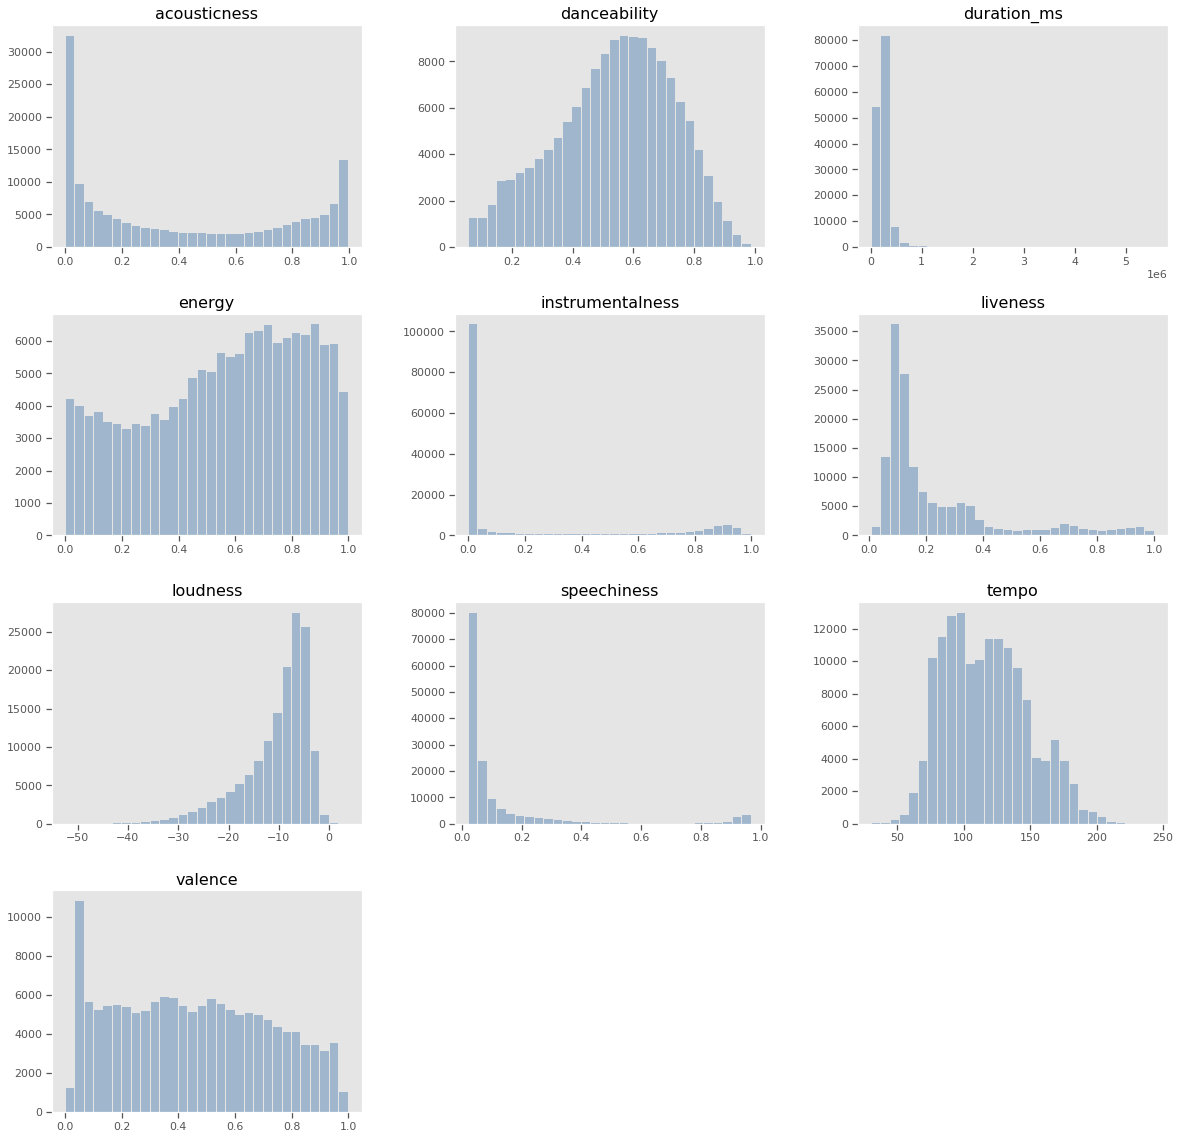

In [136]:
# plot histograms for quantitative variables
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":16,"axes.labelsize":15})  
num_df.hist(bins=30, grid=False, figsize=(20,20), layout=(4,3), color='#9FB6CD', rwidth=0.9);

Subsequently, there will be a more detailed examination of relationships between variables and, most importantly, how each attribute affects valence. Thus, it will give an indication of which are the statistically important attributes and should be included in the predictive model.

* By plotting a **correlation matrix**, we explore the associations between numerical features.

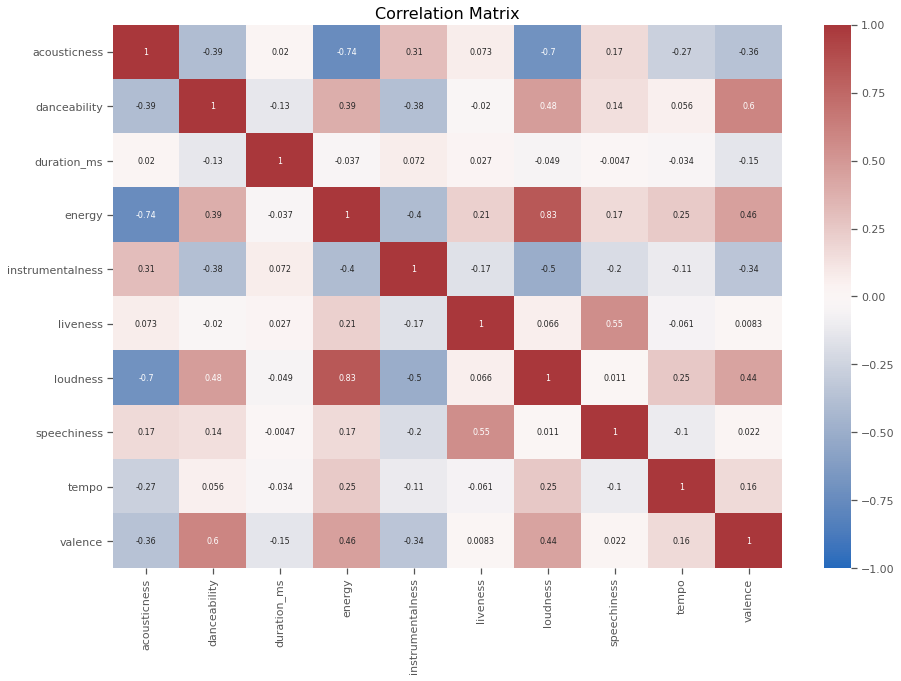

In [137]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(num_df.corr(), annot=True, cmap='vlag', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('Correlation Matrix')
plt.show()
plt.style.use('ggplot')

The bivariate visualizations observed in correlation matrix depict:

* a strong relationship between **loudness** and **energy** since the Pearson coefficient is *0.83*, which shows a possible multicollinearity effect between the two predictors

* valence is **positively** correlated to danceability (0.60 Pearson coefficient), energy (0.46 Pearson coefficient) and loudness of a song (0.44 Pearson coefficient) 
and **negatively** correlated to acousticness (-0.36 Pearson coefficient), instrumentalness (-0.34 Pearson coefficient) and duration of a song (-0.15 Pearson coefficient).

To explore the associations between qualitative variables (mode, key and time signature) and valence, we use boxplots and hypothesis tests for means. 

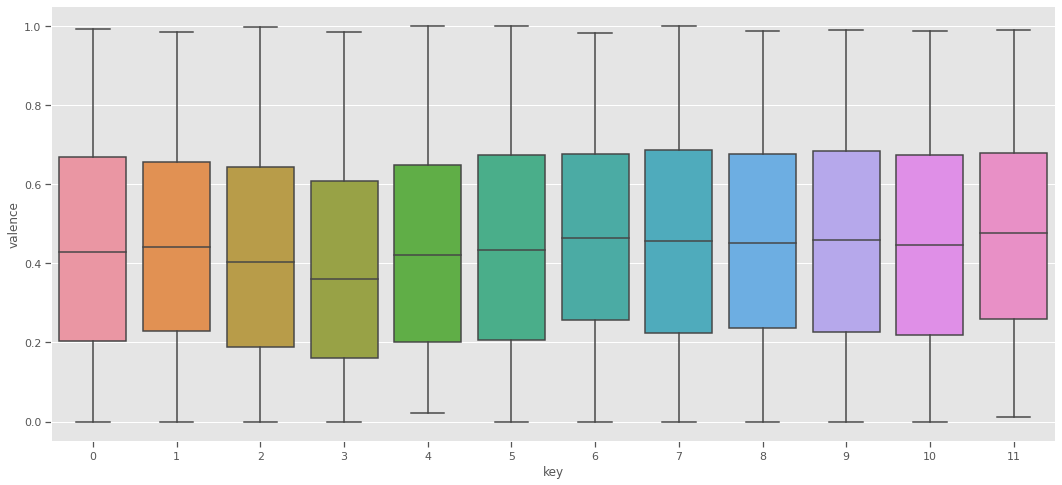

In [138]:
# plot boxplots for association between key and valence
plt.figure(figsize=(18, 8))
sns.boxplot(x=tracks_df['key'], y=tracks_df['valence']);

In [18]:
# ANOVA Test
key_model = smf.ols('valence ~ C(key)', data=tracks_df).fit()
sm.stats.anova_lm(key_model, typ=2)

,sum_sq,df,F,PR(>F)
C(key),38.426485,11.0,48.183373,2.006836e-106
Residual,10603.700310,146257.0,NaN,NaN


Since p-value is almost zero, it is assumed that key influences valence significantly.

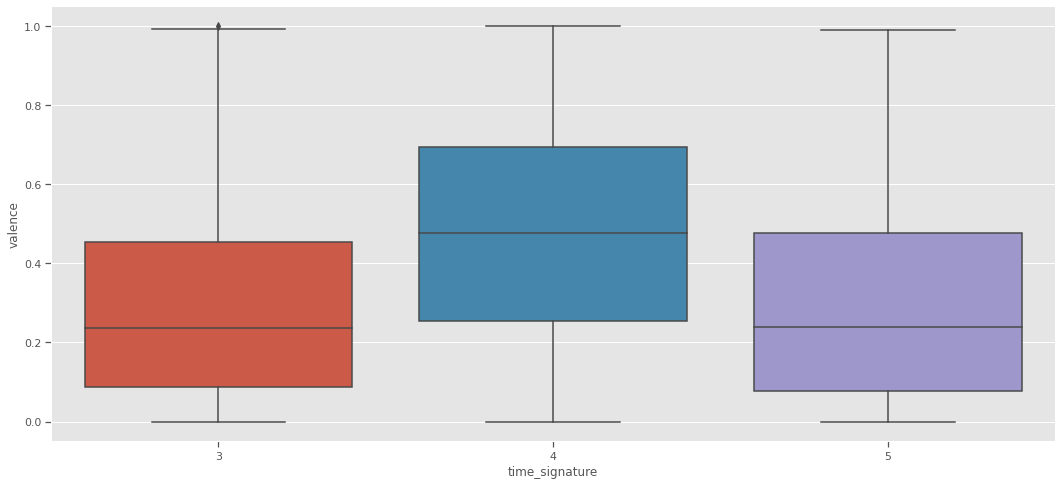

In [19]:
# plot boxplots for association between time signature and valence
plt.figure(figsize=(18, 8))
sns.boxplot(x=tracks_df['time_signature'], y=tracks_df['valence']);

In [20]:
# ANOVA Test
time_model = smf.ols('valence ~ C(time_signature)', data=tracks_df).fit()
sm.stats.anova_lm(time_model, typ=2)

,sum_sq,df,F,PR(>F)
C(time_signature),608.105497,2.0,4432.179082,0.0
Residual,10034.021298,146266.0,NaN,NaN


Since p-value is zero, it is assumed that time signature influences valence significantly.

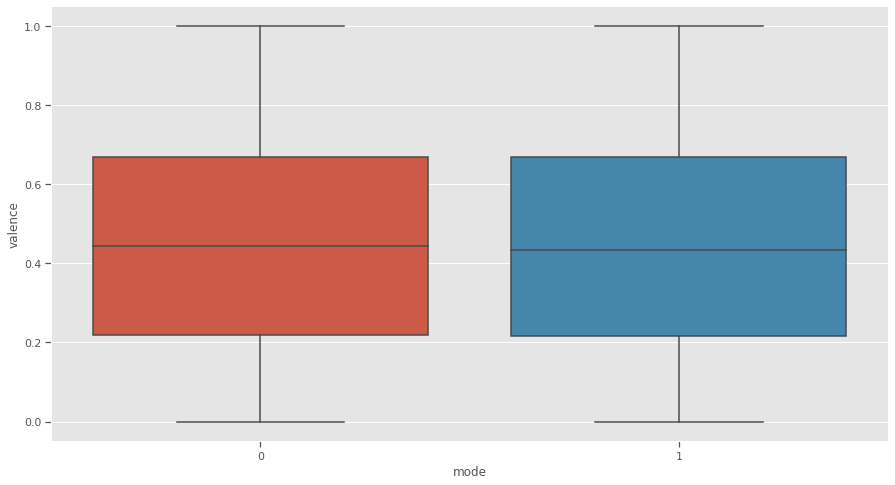

In [21]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=tracks_df['mode'], y=tracks_df['valence']);

In [22]:
# ANOVA Test
mode_model = smf.ols('valence ~ C(mode)', data=tracks_df).fit()
sm.stats.anova_lm(mode_model, typ=2)

,sum_sq,df,F,PR(>F)
C(mode),0.001301,1.0,0.017877,0.893637
Residual,10642.125495,146267.0,NaN,NaN


Since p-value is higher than 0.05, it is assumed that mode has no significant influence on valence, as observed also from the boxplots.

### One-hot encoding

We proceed with one-hot encoding for the categorical variables <code>key</code> and <code>time signature</code> in order to represent them as binary vectors. 
We use `drop_first` to remove the first category of the variables. 

In [141]:
#create dummy variables for key
key_dummies = pd.get_dummies(tracks_df['key'], prefix='key', drop_first=True)
#create dummy variables for time_signature
time_dummies = pd.get_dummies(tracks_df['time_signature'], prefix='time_signature', drop_first=True)
#drop original columns
tracks_df.drop(columns=['key','time_signature'], inplace=True)
#join data frame with dummy variables
tracks_df = tracks_df.join(key_dummies)
tracks_df = tracks_df.join(time_dummies)
tracks_df

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_4,time_signature_5
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,-1.828,1,0.0525,0.6110,0.000000,0.3460,0.816,166.969,...,0,0,0,0,0,0,0,0,1,0
0BjC1NfoEOOusryehmNudP,0.591,0.737,-5.559,0,0.0877,0.2460,0.000000,0.1510,0.815,174.003,...,0,0,1,0,0,0,0,0,1,0
0CoSDzoNIKCRs124s9uTVy,0.663,0.131,-13.879,0,0.0362,0.9520,0.000000,0.1030,0.368,99.488,...,0,0,0,0,0,0,0,0,0,1
0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,-12.178,1,0.0390,0.7030,0.000000,0.0985,0.226,171.782,...,0,0,0,0,0,0,0,0,1,0
0IuslXpMROHdEPvSl1fTQK,0.331,0.225,-21.150,1,0.0456,0.9500,0.123000,0.2020,0.390,140.576,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.611,0.493,-9.297,1,0.0354,0.1130,0.000000,0.1050,0.443,115.920,...,0,0,0,0,0,0,0,0,1,0
1U0OMWvR89Cm20vCNar50f,0.736,0.701,-4.345,0,0.1000,0.2310,0.000000,0.2030,0.770,99.991,...,0,0,0,0,0,0,1,0,1,0
2gGqKJWfWbToha2YmDxnnj,0.802,0.516,-9.014,1,0.2140,0.1040,0.000472,0.1050,0.482,175.663,...,0,0,0,0,0,0,0,0,1,0
1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,-6.944,0,0.0337,0.0329,0.000880,0.2370,0.969,113.830,...,1,0,0,0,0,0,0,0,1,0


### Scaling

We then scale the numerical variables, as they have different measurement units and it will be needed for models that use distances.

In [149]:
scaler = StandardScaler()
tracks_df2 = tracks_df.copy()
tracks_df2[['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo','loudness','duration_ms']] = scaler.fit_transform(tracks_df2[['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo','loudness','duration_ms']])
tracks_df2.describe()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_4,time_signature_5
count,1.462690e+05,1.462690e+05,1.462690e+05,146269.000000,1.462690e+05,1.462690e+05,1.462690e+05,1.462690e+05,1.462690e+05,1.462690e+05,...,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000,146269.000000
mean,4.277792e-16,2.618139e-16,-2.088952e-16,0.659743,-2.839861e-15,1.956097e-14,-2.906520e-14,5.281643e-15,9.531799e-16,4.936689e-16,...,0.075860,0.087982,0.063814,0.116785,0.062884,0.099782,0.067731,0.072073,0.849360,0.026533
std,1.000003e+00,1.000003e+00,1.000003e+00,0.473797,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,0.264775,0.283269,0.244422,0.321165,0.242755,0.299710,0.251285,0.258609,0.357699,0.160715
min,-2.492603e+00,-1.979023e+00,-6.411874e+00,0.000000,-5.150296e-01,-1.109547e+00,-5.484825e-01,-1.018801e+00,-1.669209e+00,-2.763985e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.707795e-01,-7.870100e-01,-4.373893e-01,0.000000,-4.431540e-01,-9.851996e-01,-5.484825e-01,-6.077192e-01,-8.647168e-01,-8.006888e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,9.198890e-02,1.338225e-01,3.109617e-01,1.000000,-3.829340e-01,-3.093966e-01,-5.482176e-01,-4.509250e-01,-4.168828e-02,-6.736436e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.509793e-01,8.476461e-01,7.110762e-01,1.000000,-1.274844e-01,1.063835e+00,-1.658294e-01,2.558186e-01,8.072916e-01,6.869604e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.333594e+00,1.586454e+00,2.138405e+00,1.000000,4.073350e+00,1.582852e+00,2.485410e+00,3.616361e+00,2.038127e+00,4.023472e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Model selection using step-wise methods

In order to get the best predictive model for valence, we have to remove some insignificant covariates. Therefore, we implement step-wise variable selection algorithms.

* The *Adjusted R-squared* is used to coompare the models, which is a goodness-of-fit measure for linear models adjusted for the number of predictors in the model. 

* It should be noted that the standardized data is used, in order to be able to interpret and compare the coefficients for each variable.

In [143]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [144]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [145]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1
    
    for i in range(1, p):
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [152]:
best_model_forward, best_models_forward = forward_stepwise_selection(tracks_df2, 'valence')
print('Best overall model:', len(best_model_forward.model.exog_names), best_model_forward.model.exog_names)

Fitted 352 models
Best overall model: 24 ['intercept', 'danceability', 'energy', 'explicit', 'year', 'duration_ms', 'tempo', 'acousticness', 'speechiness', 'instrumentalness', 'loudness', 'key_1', 'mode', 'time_signature_4', 'key_2', 'key_4', 'key_5', 'liveness', 'key_7', 'key_9', 'key_10', 'key_11', 'key_6', 'key_8']


In [153]:
best_model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     5894.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:19:46   Log-Likelihood:            -1.5958e+05
No. Observations:              146269   AIC:                         3.192e+05
Df Residuals:                  146245   BIC:                         3.194e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            9.8690      0.206     47.792      0.000       9.464      10.274
danceability         0.5397      0.002    229.564      0.000       0.535       0.544
energy               0.4705      0.004    110.736      0.000       0.462       0.479
explicit            -0.3420      0.006    -54.347      0.000      -0.354      -0.330
year                -0.0049      0.000    -47.837      0.000      -0.005      -0.005
duration_ms         -0.0682      0.002    -35.746      0.000      -0.072      -0.064
tempo                0.0707      0.002     35.589      0.000       0.067       0.075
acousticness         0.1518      0.003     46.675      0.000       0.145       0.158
speechiness         -0.1005      0.003    -36.259      0.000      -0.106      -0.095
instrumentalness    -0.0982      0.002    -42.510      0.000      -0.103      -0.094
loudness            -0.1426      0.004    -36.002      0.000      -0.150      -0.135
key_1               -0.1026      0.008    -13.029      0.000      -0.118      -0.087
mode                 0.0436      0.004     10.541      0.000       0.035       0.052
time_signature_4     0.0397      0.006      6.791      0.000       0.028       0.051
key_2               -0.0401      0.008     -5.315      0.000      -0.055      -0.025
key_4               -0.0387      0.008     -4.578      0.000      -0.055      -0.022
key_5                0.0339      0.008      4.232      0.000       0.018       0.050
liveness            -0.0113      0.002     -4.820      0.000      -0.016      -0.007
key_7                0.0213      0.007      2.906      0.004       0.007       0.036
key_9                0.0143      0.008      1.850      0.064      -0.001       0.029
key_10               0.0113      0.009      1.283      0.199      -0.006       0.028
key_11              -0.0279      0.009     -3.220      0.001      -0.045      -0.011
key_6               -0.0261      0.009     -2.908      0.004      -0.044      -0.009
key_8               -0.0245      0.009     -2.740      0.006      -0.042      -0.007
==============================================================================
Omnibus:                     6170.747   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19437.594
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       4.773   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The forward step-wise method removes only two variables (key_3 and time_signature_5). The summary of the model above indicates that the variables key_9 and key_10 are also not statistically significant (p-value > 0.05) and they should probably be removed from the model. We will try using the backward step-wise method for better results.

In [154]:
def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [155]:
def backward_stepwise_selection(data, exog):

    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1

    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [156]:
best_model_backward, best_models_backward = backward_stepwise_selection(tracks_df2, 'valence')
print('Best overall model:', len(best_model_backward.model.exog_names), best_model_backward.model.exog_names)

Fitted 352 models
Best overall model: 24 ['intercept', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'explicit', 'year', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_4']


In [157]:
best_model_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     5894.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:21:28   Log-Likelihood:            -1.5958e+05
No. Observations:              146269   AIC:                         3.192e+05
Df Residuals:                  146245   BIC:                         3.194e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            9.8690      0.206     47.792      0.000       9.464      10.274
danceability         0.5397      0.002    229.564      0.000       0.535       0.544
energy               0.4705      0.004    110.736      0.000       0.462       0.479
loudness            -0.1426      0.004    -36.002      0.000      -0.150      -0.135
mode                 0.0436      0.004     10.541      0.000       0.035       0.052
speechiness         -0.1005      0.003    -36.259      0.000      -0.106      -0.095
acousticness         0.1518      0.003     46.675      0.000       0.145       0.158
instrumentalness    -0.0982      0.002    -42.510      0.000      -0.103      -0.094
liveness            -0.0113      0.002     -4.820      0.000      -0.016      -0.007
tempo                0.0707      0.002     35.589      0.000       0.067       0.075
duration_ms         -0.0682      0.002    -35.746      0.000      -0.072      -0.064
explicit            -0.3420      0.006    -54.347      0.000      -0.354      -0.330
year                -0.0049      0.000    -47.837      0.000      -0.005      -0.005
key_1               -0.1026      0.008    -13.029      0.000      -0.118      -0.087
key_2               -0.0401      0.008     -5.315      0.000      -0.055      -0.025
key_4               -0.0387      0.008     -4.578      0.000      -0.055      -0.022
key_5                0.0339      0.008      4.232      0.000       0.018       0.050
key_6               -0.0261      0.009     -2.908      0.004      -0.044      -0.009
key_7                0.0213      0.007      2.906      0.004       0.007       0.036
key_8               -0.0245      0.009     -2.740      0.006      -0.042      -0.007
key_9                0.0143      0.008      1.850      0.064      -0.001       0.029
key_10               0.0113      0.009      1.283      0.199      -0.006       0.028
key_11              -0.0279      0.009     -3.220      0.001      -0.045      -0.011
time_signature_4     0.0397      0.006      6.791      0.000       0.028       0.051
==============================================================================
Omnibus:                     6170.747   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19437.594
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       4.773   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The backward step-wise method concludes to the same model with the forward. Nevertheless, we will remove the variables key_9 and key_10 from the model because of the high p-values and run the summary again.

In [160]:
best_model_backward2, best_models_backward2 = backward_stepwise_selection(tracks_df2.drop(['key_9','key_10'], axis=1), 'valence')
print('Best overall model:', len(best_model_backward2.model.exog_names), best_model_backward2.model.exog_names)

Fitted 301 models
Best overall model: 22 ['intercept', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'explicit', 'year', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_11', 'time_signature_4']


In [162]:
best_model_backward2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     6455.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:32:09   Log-Likelihood:            -1.5958e+05
No. Observations:              146269   AIC:                         3.192e+05
Df Residuals:                  146247   BIC:                         3.194e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            9.8790      0.206     47.855      0.000       9.474      10.284
danceability         0.5397      0.002    229.626      0.000       0.535       0.544
energy               0.4707      0.004    110.804      0.000       0.462       0.479
loudness            -0.1428      0.004    -36.039      0.000      -0.151      -0.135
mode                 0.0427      0.004     10.401      0.000       0.035       0.051
speechiness         -0.1004      0.003    -36.232      0.000      -0.106      -0.095
acousticness         0.1517      0.003     46.650      0.000       0.145       0.158
instrumentalness    -0.0982      0.002    -42.521      0.000      -0.103      -0.094
liveness            -0.0114      0.002     -4.834      0.000      -0.016      -0.007
tempo                0.0706      0.002     35.585      0.000       0.067       0.075
duration_ms         -0.0681      0.002    -35.735      0.000      -0.072      -0.064
explicit            -0.3420      0.006    -54.351      0.000      -0.354      -0.330
year                -0.0049      0.000    -47.852      0.000      -0.005      -0.005
key_1               -0.1095      0.007    -15.586      0.000      -0.123      -0.096
key_2               -0.0469      0.007     -7.005      0.000      -0.060      -0.034
key_4               -0.0457      0.008     -5.982      0.000      -0.061      -0.031
key_5                0.0270      0.007      3.762      0.000       0.013       0.041
key_6               -0.0332      0.008     -4.036      0.000      -0.049      -0.017
key_7                0.0146      0.006      2.254      0.024       0.002       0.027
key_8               -0.0313      0.008     -3.804      0.000      -0.047      -0.015
key_11              -0.0350      0.008     -4.459      0.000      -0.050      -0.020
time_signature_4     0.0397      0.006      6.789      0.000       0.028       0.051
==============================================================================
Omnibus:                     6179.914   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19483.683
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       4.775   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It is observed from the summary of the best model that:
* All variables are statistically significant (p-value<0.05).
* The R-squared metric is **48.1%**, which means that 48.1% of the valence variation is explained by the predictors.
* The features that **increase** valence the most are *danceability and energy*. Specifically,
  * One unit increase in the danceability variable while holding the other predictors in the model constant, increases valence variable by 0.54.
  * One unit increase in the energy variable while holding the other predictors in the model constant, increases valence variable by 0.47.
* The features that **decrease** valence the most are *loudness and speechiness*. Specifically,
  * One unit increase in the loudness variable while holding the other predictors in the model constant, decreases valence variable by 0.14.
  * One unit increase in the speechiness variable while holding the other predictors in the model constant, decreases valence variable by 0.10.
  
The results are reasonable since danceability and energy are likely to make someone happier, while loudness and speechiness in a song might not be very pleasant.

## Q2: Predict Valence

In this section, we will use machine learning algorithms to construct several models, which will try to efficiently predict the valence of a song having as input the variables that we previously explored.

* We initially split the data in train and test set. We will evaluate our predictions on a holdout 20% testing dataset.
* To compare and evaluate the models, we calculate the Mean Square Error and Mean Absolute Error. 
* We try to tune the hyperparameters as best as we can to minimize these errors. 
* For hyperparameter tuning we use the RandomizedSearchCV and the GridSearchCV technique from scikit-learn, but in most cases they were very computationally expensive to run and therefore they are commented out. They also did not always yield the best possible results regarding MAE. 
* We also create charts that illustrate the ranking of feature importance for each method, to find which variables contribute the most in predicting the valence of a song.


The following methods will be used to predict valence:

* `Linear Regression`
* `Decision Tree` 
* `Random Forest`
* `XGBoost`
* `LightGBM`
* `Catboost`

We will also create charts that will illustrate the ranking of feature importance, to find which variables contribute the most in predicting the valence of a song.

### Import packages

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn import tree

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from scipy.stats import sem
from sklearn.metrics import mean_absolute_error

### Data Preparation

The train-test split is a technique for evaluating the performance of a machine learning algorithm.
The dataset is divided into two subsets. The first subset is used to fit the model and is referred to as the training dataset (80% of the initial dataset). The second subset is not used to train the model, instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset (20% of the initial dataset).

In [164]:
X_train, X_test, y_train, y_test = train_test_split(tracks_df.drop(['valence'] , axis=1), 
                                                    tracks_df['valence'], test_size=0.20, random_state=12345)

### Linear Regression

Linear Regression is a supervised machine learning algorithm where the predicted output is continuous and has a constant slope. There are no hyperparameters in linear regression that need tuning.

In [251]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
MSE1 = round(mean_squared_error(y_test, y_pred),4)
MAE1 = round(mean_absolute_error(y_test, y_pred),4)
score1 = round(linear_reg.score(X_test, y_test),4)
print("Mean Squared Error for Linear Regression:", "{:.4f}".format(MSE1) , " \nMean Absolute Error for Linear Regression:", "{:.4f}".format(MAE1), 
      " \nR Squared:", "{:.4f}".format(score1))

Mean Squared Error for Linear Regression: 0.0374  
Mean Absolute Error for Linear Regression: 0.1548  
R Squared: 0.4852


Importance of audio features for Linear Regression 

1. Variable 0 danceability (0.755283)
2. Variable 1 energy (0.451726)
3. Variable 4 speechiness (0.131644)
4. Variable 5 acousticness (0.109435)
5. Variable 10 explicit (0.092807)
6. Variable 6 instrumentalness (0.080309)
7. Variable 12 key_1 (0.026711)
8. Variable 7 liveness (0.015406)
9. Variable 3 mode (0.011112)
10. Variable 16 key_5 (0.010415)
11. Variable 23 time_signature_4 (0.010169)
12. Variable 13 key_2 (0.010158)
13. Variable 15 key_4 (0.008897)
14. Variable 18 key_7 (0.006747)
15. Variable 17 key_6 (0.006010)
16. Variable 2 loudness (0.005847)
17. Variable 22 key_11 (0.005719)
18. Variable 19 key_8 (0.004620)
19. Variable 14 key_3 (0.004510)
20. Variable 20 key_9 (0.004326)
21. Variable 21 key_10 (0.003407)
22. Variable 11 year (0.001266)
23. Variable 24 time_signature_5 (0.000730)
24. Variable 8 tempo (0.000608)
25. Variable 9 duration_ms (0.000000)


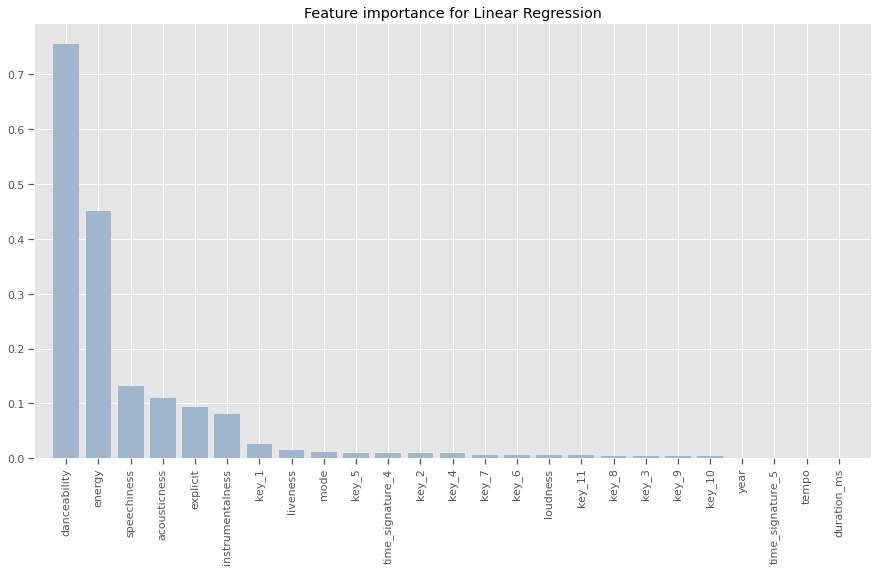

In [269]:
importances = np.abs(linear_reg.coef_)
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for Linear Regression' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))

plt.figure(figsize=(15, 8))
plt.title("Feature importance for Linear Regression")
plt.bar(range(X_train.shape[1]), importances[indices],tick_label=[list(X_train.columns)[x] for x in indices],
        color="#9FB6CD",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

The following methods that we will use belong to the category of tree based learning algorithms. Specifically, we implement Decision Tree Regressor, Random Forest Regressor, XGBoost Regressor and LightGBM Regressor.

### Decision Tree

#### Decision Tree Regressor
Decision tree's hyperparameters that need tuning are:
* *max_depth* (the maximum depth of the tree. By reducing this meter, we can preclude the tree from learning all training samples thereby, preventing over-fitting)
* *min_samples_leaf* (the minimum number of samples required to be at a leaf node)

In [263]:
# Hyperparameters tuning
parameters = [
  {'max_depth': list(range(1, 20))},
 ]

cv = KFold(n_splits=10, shuffle=True, random_state=12345)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=10)
{'max_depth': 10}


In [261]:
# Desision Tree Regressor
decision_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf = 100)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
MSE2 = round(mean_squared_error(y_test, y_pred),4)
MAE2 = round(mean_absolute_error(y_test, y_pred),4)

print("Mean Squared Error for Decision Tree:", "{:.4f}".format(MSE2) , 
      " \nMean Absolute Error for Decision Tree::", "{:.4f}".format(MAE2))

Mean Squared Error for Decision Tree: 0.0341  
Mean Absolute Error for Decision Tree:: 0.1440


Importance of audio features for Decision Tree 

1. Variable 0 danceability (0.593701)
2. Variable 1 energy (0.183595)
3. Variable 11 year (0.068847)
4. Variable 9 duration_ms (0.039065)
5. Variable 4 speechiness (0.037762)
6. Variable 8 tempo (0.024939)
7. Variable 10 explicit (0.016402)
8. Variable 6 instrumentalness (0.013886)
9. Variable 5 acousticness (0.011822)
10. Variable 2 loudness (0.005661)
11. Variable 7 liveness (0.003662)
12. Variable 3 mode (0.000657)
13. Variable 24 time_signature_5 (0.000000)
14. Variable 23 time_signature_4 (0.000000)
15. Variable 13 key_2 (0.000000)
16. Variable 14 key_3 (0.000000)
17. Variable 15 key_4 (0.000000)
18. Variable 16 key_5 (0.000000)
19. Variable 17 key_6 (0.000000)
20. Variable 18 key_7 (0.000000)
21. Variable 19 key_8 (0.000000)
22. Variable 20 key_9 (0.000000)
23. Variable 21 key_10 (0.000000)
24. Variable 22 key_11 (0.000000)
25. Variable 12 key_1 (0.000000)


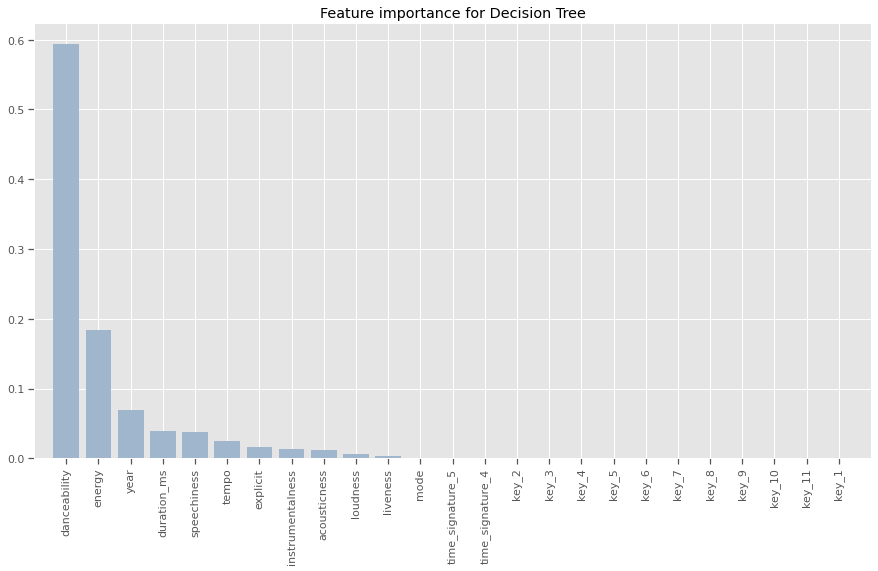

In [281]:
# Feature importance plot
importances = decision_tree.feature_importances_
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for Decision Tree' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(15, 8))
plt.title("Feature importance for Decision Tree")
plt.bar(range(X_train.shape[1]), importances[indices], tick_label=[list(X_train.columns)[x] for x in indices],
        color="#9FB6CD",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### Random Forest


#### RandomForestRegressor

Random forests are supervised machine learning models that train multiple decision trees and integrate the results by averaging them. Random forest's **hyperparameters** that need tuning are:
* *max_depth* (the maximum depth of each tree. By reducing this meter, we can preclude the tree from learning all training samples thereby, preventing over-fitting)
* *n_estimators* (the number of decision trees in random forests)
* *min_samples_leaf* (minimum number of samples required to be left at the leaf node)

In [271]:
# Random Forest Regressor
random_forest = RandomForestRegressor(max_depth = 20, n_estimators = 700, min_samples_leaf = 10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
MSE3 = round(mean_squared_error(y_test, y_pred),4)
MAE3 = round(mean_absolute_error(y_test, y_pred),4)
print("Mean Squared Error for Random Forest::", "{:.4f}".format(MSE3),
      " \nMean Absolute Error for Random Forest:", "{:.4f}".format(MAE3))

Mean Squared Error for Random Forest:: 0.0283  
Mean Absolute Error for Random Forest: 0.1305


In [ ]:
# Hyperparameters tuning
# params = {'n_estimators': [200,500,700,1000],
#           'max_depth': [10, 20 ,50, 60, 90, 100, None],
#           'min_samples_leaf': [3, 5, 7 ,10],
#           }
# clf = RandomizedSearchCV(random_forest, params, cv=cv , scoring ="neg_mean_absolute_error" )
# clf = clf.fit(X_train, y_train)
# print(clf.best_estimator_)
# print(clf.best_params_)

Importance of audio features for Random Forest 

1. Variable 0 danceability (0.467391)
2. Variable 1 energy (0.161188)
3. Variable 11 year (0.066403)
4. Variable 4 speechiness (0.058281)
5. Variable 9 duration_ms (0.056195)
6. Variable 8 tempo (0.047625)
7. Variable 5 acousticness (0.035873)
8. Variable 6 instrumentalness (0.032485)
9. Variable 2 loudness (0.030171)
10. Variable 7 liveness (0.024583)
11. Variable 10 explicit (0.013067)
12. Variable 3 mode (0.002823)
13. Variable 23 time_signature_4 (0.000650)
14. Variable 12 key_1 (0.000537)
15. Variable 18 key_7 (0.000501)
16. Variable 13 key_2 (0.000421)
17. Variable 16 key_5 (0.000404)
18. Variable 20 key_9 (0.000340)
19. Variable 17 key_6 (0.000250)
20. Variable 22 key_11 (0.000209)
21. Variable 15 key_4 (0.000207)
22. Variable 21 key_10 (0.000167)
23. Variable 19 key_8 (0.000150)
24. Variable 14 key_3 (0.000055)
25. Variable 24 time_signature_5 (0.000022)


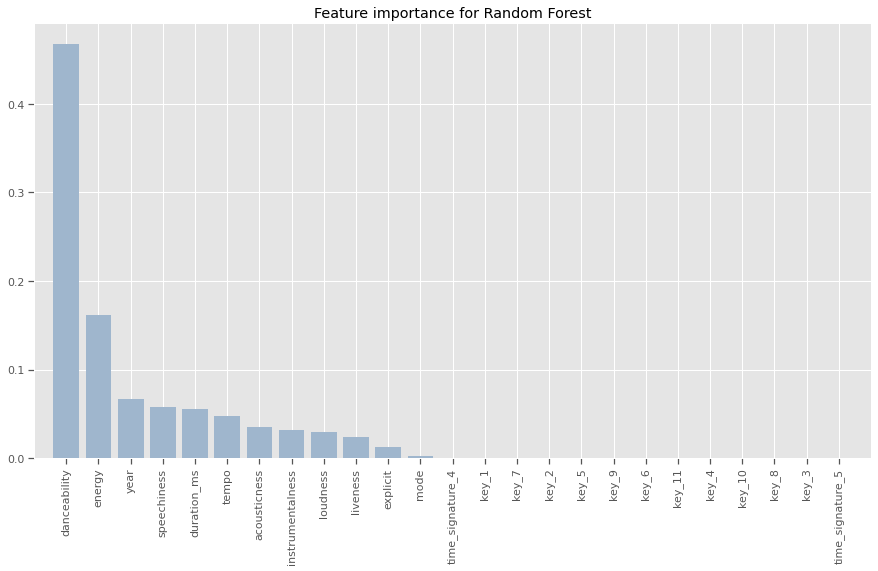

In [272]:
# Feature importance plot
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for Random Forest' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
plt.figure(figsize=(15, 8))
plt.title("Feature importance for Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color='#9FB6CD',  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### XGB Boost

#### XGB Boost Regressor 

Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.

Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems. Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

XGB Boost's **hyperparameters** that need tuning are:
* *objective* (“reg:squarederror”: Loss function for regression for predictive modeling problems)
* *max_depth* (the maximum depth of each tree. By reducing this meter, we can preclude the tree from learning all training samples thereby, preventing over-fitting)
* *n_estimators* (the number of decision trees)
* *colsample_bytree* (number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features).
* *learning_rate* (a technique to slow down the learning in the gradient boosting model by applying a weighting factor for the corrections by new trees when added to the model)

In [322]:
# XGB Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.7, 
                       learning_rate = 0.01, max_depth = 10, n_estimators = 2000)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
MSE4 = round(mean_squared_error(y_test, y_pred),4)
MAE4 = round(mean_absolute_error(y_test, y_pred),4)
print("Mean Squared Error for XGB Boost:", "{:.4f}".format(MSE4), 
      " \nMean Absolute Error for XGB Boost:", "{:.4f}".format(MAE4))

Mean Squared Error for XGB Boost: 0.0265  
Mean Absolute Error for XGB Boost: 0.1261


In [ ]:
# Hyperparameters tuning
# params = {
#         'colsample_bytree': [0.6, 0.7, 1.0],
#         'max_depth': [3, 5, 7, 10]
#         'n_estimators': [200,500,700,1000,2000],
#         'learning_rate': [0.01, 0.05]
#         }
# clf = GridSearchCV(xgb_reg, params, cv=cv , scoring ="neg_mean_absolute_error" )
# clf = clf.fit(X_train, y_train)
# print(clf.best_estimator_)
# print(clf.best_params_)

Importance of audio features for XGBoost 

1. Variable 10 explicit (0.171172)
2. Variable 0 danceability (0.169361)
3. Variable 1 energy (0.086100)
4. Variable 11 year (0.064063)
5. Variable 4 speechiness (0.043363)
6. Variable 9 duration_ms (0.041051)
7. Variable 23 time_signature_4 (0.040179)
8. Variable 2 loudness (0.036637)
9. Variable 6 instrumentalness (0.036424)
10. Variable 8 tempo (0.035745)
11. Variable 5 acousticness (0.033758)
12. Variable 7 liveness (0.025810)
13. Variable 12 key_1 (0.021336)
14. Variable 16 key_5 (0.020326)
15. Variable 17 key_6 (0.018002)
16. Variable 13 key_2 (0.017653)
17. Variable 3 mode (0.017511)
18. Variable 14 key_3 (0.017270)
19. Variable 24 time_signature_5 (0.016240)
20. Variable 18 key_7 (0.015495)
21. Variable 15 key_4 (0.015436)
22. Variable 22 key_11 (0.014770)
23. Variable 19 key_8 (0.014726)
24. Variable 21 key_10 (0.014203)
25. Variable 20 key_9 (0.013367)


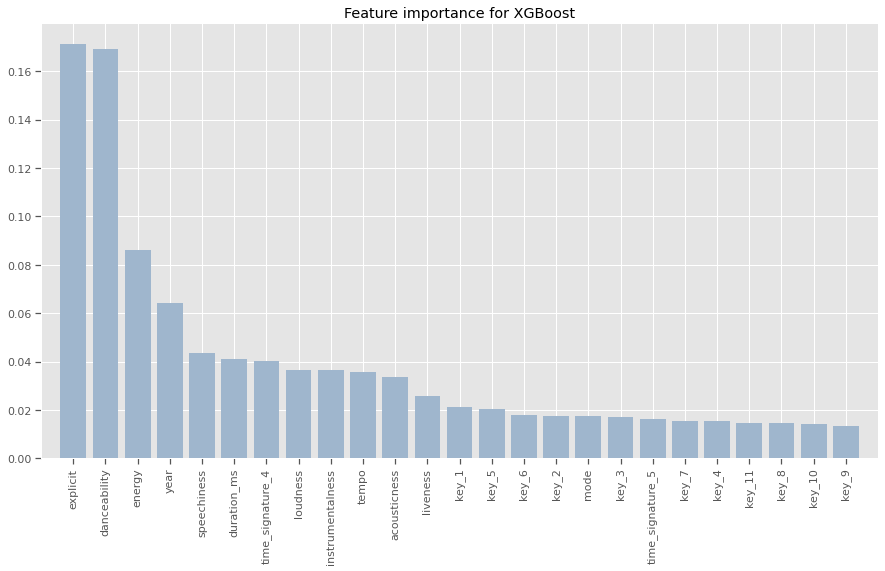

In [345]:
# Feature importance plot
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for XGBoost' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))

plt.figure(figsize=(15, 8))
plt.title("Feature importance for XGBoost")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="#9FB6CD",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### LightGBM

#### LightGBM's Regressor 

LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. 

LightGBM splits the tree leaf-wise as opposed to other boosting algorithms that grow tree level-wise. It chooses the leaf with maximum delta loss to grow. Since the leaf is fixed, the leaf-wise algorithm has lower loss compared to the level-wise algorithm.

LightGBM's **hyperparameters** that need tuning are:
* *objective* (“cross_entropy”: Loss function for regression for predictive modeling problems)
* *max_depth* (the maximum depth of each tree. By reducing this meter, we can preclude the tree from learning all training samples thereby, preventing over-fitting)
* *num_leaves* (it specifies the number of leaves in a tree)
* *n_estimators* (the number of decision trees)
* *learning_rate* (a technique to slow down the learning in the gradient boosting model by applying a weighting factor for the corrections by new trees when added to the model)

In [356]:
# LightGBM Regressor
lgbm_reg = LGBMRegressor(objective = 'cross_entropy',learning_rate=0.05, 
                         max_depth = 10, num_leaves=50, n_estimators=2000)
lgbm_reg.fit(X_train, y_train)
y_pred = lgbm_reg.predict(X_test)
MSE5 = round(mean_squared_error(y_test, y_pred),4)
MAE5 = round(mean_absolute_error(y_test, y_pred),4)
print("Mean Squared Error for LightGBM:", "{:.4f}".format(MSE5) , 
      " \nMean Absolute Error for LightGBM:", "{:.4f}".format(MAE5))

Mean Squared Error for LightGBM: 0.0267  
Mean Absolute Error for LightGBM: 0.1255


In [ ]:
# Hyperparameters tuning
# params ={
#        'num_leaves' : [20, 30, 50, 60, 80 ,100],
#         'max_depth' : [10, 15 , 25 ,50 , 70],
#         'n_estimators': [200,500,700,1000,2000],
#         'learning_rate': [0.01, 0.05]
# }
# clf = RandomizedSearchCV(lgbm_reg, params, cv=cv , scoring ="neg_mean_absolute_error" )
# clf =  clf.fit(X_train, y_train)
# print(clf.best_estimator_)
# print(clf.best_params_)

Importance of audio features for LightGBM 

1. Variable 1 energy (10418.000000)
2. Variable 9 duration_ms (10120.000000)
3. Variable 4 speechiness (10044.000000)
4. Variable 0 danceability (9917.000000)
5. Variable 5 acousticness (9860.000000)
6. Variable 8 tempo (9507.000000)
7. Variable 2 loudness (9433.000000)
8. Variable 7 liveness (8773.000000)
9. Variable 6 instrumentalness (8171.000000)
10. Variable 11 year (6779.000000)
11. Variable 3 mode (930.000000)
12. Variable 10 explicit (668.000000)
13. Variable 18 key_7 (387.000000)
14. Variable 23 time_signature_4 (377.000000)
15. Variable 13 key_2 (350.000000)
16. Variable 12 key_1 (348.000000)
17. Variable 22 key_11 (296.000000)
18. Variable 17 key_6 (270.000000)
19. Variable 20 key_9 (248.000000)
20. Variable 16 key_5 (231.000000)
21. Variable 15 key_4 (221.000000)
22. Variable 19 key_8 (220.000000)
23. Variable 21 key_10 (172.000000)
24. Variable 14 key_3 (130.000000)
25. Variable 24 time_signature_5 (130.000000)


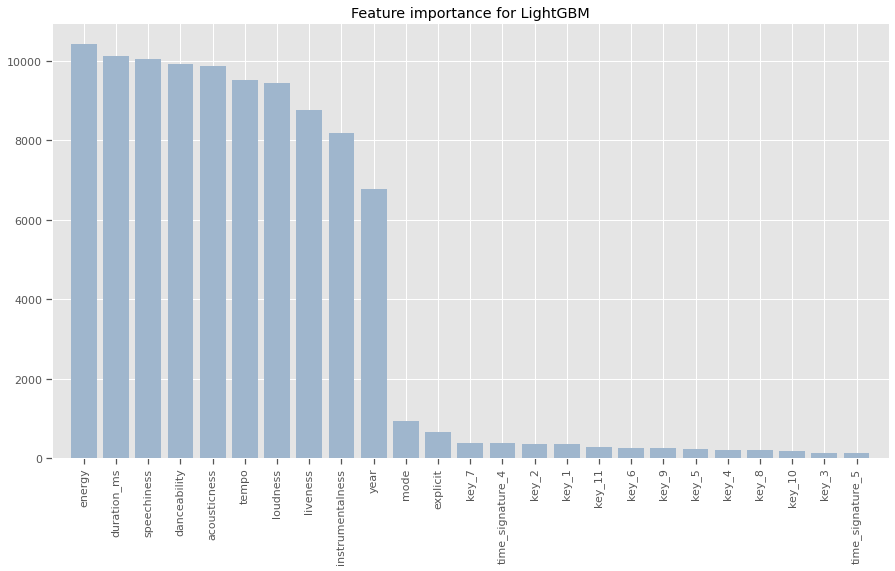

In [346]:
# Feature importance plot
importances = lgbm_reg.feature_importances_
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for LightGBM' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(15, 8))
plt.title("Feature importance for LightGBM")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="#9FB6CD",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### CatBoost

#### CatBoost's Regressor 

CatBoost is also an algorithm for gradient boosting on decision trees. CatBoost grows oblivious trees, which means that the trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations. The oblivious tree procedure allows for a simple fitting scheme and efficiency on CPUs, while the tree structure operates as a regularization to find an optimal solution and avoid overfitting.

CatBoost's **hyperparameters** that need tuning are:
* *max_depth* (the maximum depth of each tree)
* *n_estimators* (the number of decision trees)

In [339]:
# CatBoost Regressor
cb_reg = cb.CatBoostRegressor(silent = True,  depth= 10,  n_estimators=2000, iterations = None )
cb_reg.fit(X_train, y_train)
y_pred = cb_reg.predict(X_test)
MSE6 = round(mean_squared_error(y_test, y_pred),4)
MAE6 = round(mean_absolute_error(y_test, y_pred),4)
print("Mean Squared Error for Catboost:", "{:.4f}".format(MSE6) , 
      " \nMean Absolute Error for Catboost:", "{:.4f}".format(MAE6))

Mean Squared Error for Catboost: 0.0264  
Mean Absolute Error for Catboost: 0.1252


In [ ]:
# Hyperparameters tuning
# params ={
#         'depth' : [10, 15 , 25 , 50 , 70],
#         'n_estimators': [200,500,700,1000,2000],
# }
# clf = RandomizedSearchCV(cb_reg, params, cv=cv , scoring ="neg_mean_absolute_error" )
# clf =  clf.fit(X_train, y_train)
# print(clf.best_estimator_)
# print(clf.best_params_)

Importance of audio features for CatBoost 

1. Variable 0 danceability (30.939639)
2. Variable 1 energy (20.471514)
3. Variable 11 year (11.445330)
4. Variable 4 speechiness (8.614033)
5. Variable 9 duration_ms (7.675444)
6. Variable 8 tempo (5.078665)
7. Variable 10 explicit (4.992808)
8. Variable 6 instrumentalness (3.876414)
9. Variable 5 acousticness (3.544259)
10. Variable 7 liveness (1.846159)
11. Variable 2 loudness (1.439870)
12. Variable 3 mode (0.027432)
13. Variable 23 time_signature_4 (0.026941)
14. Variable 12 key_1 (0.021493)
15. Variable 13 key_2 (0.000000)
16. Variable 14 key_3 (0.000000)
17. Variable 15 key_4 (0.000000)
18. Variable 16 key_5 (0.000000)
19. Variable 17 key_6 (0.000000)
20. Variable 18 key_7 (0.000000)
21. Variable 19 key_8 (0.000000)
22. Variable 20 key_9 (0.000000)
23. Variable 21 key_10 (0.000000)
24. Variable 22 key_11 (0.000000)
25. Variable 24 time_signature_5 (0.000000)


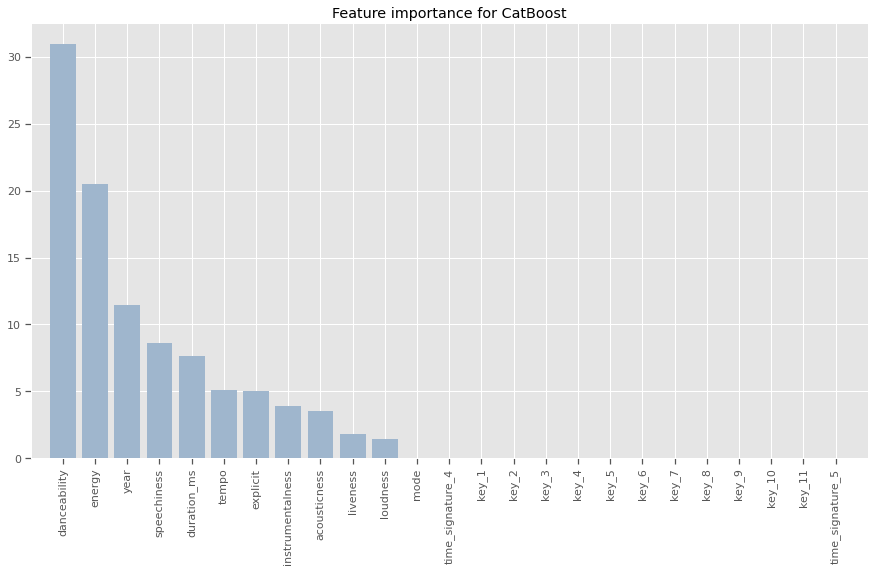

In [344]:
# Feature importance plot
importances = cat_reg.feature_importances_
indices = np.argsort(importances)[::-1]

print('\033[1m' + 'Importance of audio features for CatBoost' + '\033[0m','\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(15, 8))
plt.title("Feature importance for CatBoost")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="#9FB6CD",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

By checking at the feature importance plots, we observe that danceability and energy are in almost all cases the most important ones, which confirms the results of the previous section. Moreover, explicit also appears to be the most important feature in XGBoost method. The plot for LightGBM on the other hand, shows that all numerical features are almost equally important. Finally, in all cases, the least important predictors are the categorical variables, key and time signature.

### Out-of-sample testing

The final step is to use the validation data provided to calculate the out-of sample MSE and MAE for each model. The dataset `spotify_ids` has 1162 song ids but not their audio features. To get the audio features, we will connect to Spotify's API as previously. We process the data in the same way and we will attempt to predict valence. At the end, we will compare the results and assess the predictive ability based on Mean Absolute Error (MAE).

In [166]:
# Test songs dataset 
test_df = pd.read_csv('data/spotify_ids.txt', header = None, names = ['track_id'])

In [167]:
client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [171]:
features_test = {}
extra_features_test = {}
test_track_ids = list(test_df['track_id'].unique())

In [172]:
# Spotify API download track features(100 each time)
start = 0
num_tracks = 100
while start < len(test_track_ids):
    tracks_batch = test_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features_test.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

In [176]:
# Spotify API download extra features(50 each time)
start = 0
num_tracks = 50
while start < len(test_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = test_track_ids[start:start+num_tracks]
    features_batch = sp.tracks(tracks_batch)
    extra_features_test.update({ track_id : {'explicit': features['explicit'], 'release_date': features['album']['release_date']} 
                        for track_id, features in zip(tracks_batch, features_batch['tracks']) })
    start += num_tracks

getting from 0 to 50
getting from 50 to 100
getting from 100 to 150
getting from 150 to 200
getting from 200 to 250
getting from 250 to 300
getting from 300 to 350
getting from 350 to 400
getting from 400 to 450
getting from 450 to 500
getting from 500 to 550
getting from 550 to 600
getting from 600 to 650
getting from 650 to 700
getting from 700 to 750
getting from 750 to 800
getting from 800 to 850
getting from 850 to 900
getting from 900 to 950
getting from 950 to 1000
getting from 1000 to 1050
getting from 1050 to 1100
getting from 1100 to 1150
getting from 1150 to 1200


In [177]:
# turn features dictionary into data frame
test = pd.DataFrame.from_dict(features_test, orient='index')
test = test.drop(['type','id','uri','track_href','analysis_url'],axis=1)
# turn extra features dictionary into data frame while making "explicit" binary and keeping only the year from "release_date"
extra_test = pd.DataFrame.from_dict(extra_features_test, orient='index')
extra_test['explicit'] = np.where(extra_test['explicit'] == True, 1, 0)
extra_test['year'] = extra_test['release_date'].apply(lambda x: int(x[0:4]))
extra_test.drop(columns='release_date', inplace=True)
# merge data frames
test = test.merge(extra_test, left_index=True, right_index=True, how='inner')
test

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,year
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,242014,4,1,2021
5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,215627,4,1,2020
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,4,0,2020
4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,205090,4,1,2020
5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,205458,4,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4lUmnwRybYH7mMzf16xB0y,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,257428,4,1,2021
1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,187310,4,0,2021
3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,209299,4,1,2021
3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,202204,4,0,2021


In [178]:
test_df = test.copy()
test_df = test_df.loc[(test_df['time_signature']>=3) & (test_df['time_signature'] <=7)]

In [179]:
#create dummy variables for key
key_dummies = pd.get_dummies(test_df['key'], prefix='key', drop_first=True)
#create dummy variables for time_signature
time_dummies = pd.get_dummies(test_df['time_signature'], prefix='time_signature', drop_first=True)
#drop original columns
test_df.drop(columns=['key','time_signature'], inplace=True)
#join data frame with dummy variables
test_df = test_df.join(key_dummies)
test_df = test_df.join(time_dummies)
test_df

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_4,time_signature_5
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,...,0,0,0,0,0,0,1,0,1,0
5QO79kh1waicV47BqGRL3g,0.680,0.826,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,...,0,0,0,0,0,0,0,0,1,0
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,...,0,0,0,0,0,0,0,0,1,0
4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,...,1,0,0,0,0,0,0,0,1,0
5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4lUmnwRybYH7mMzf16xB0y,0.596,0.650,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,...,0,0,0,0,0,1,0,0,1,0
1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,...,1,0,0,0,0,0,0,0,1,0
3E3pb3qH11iny6TFDJvsg5,0.754,0.660,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,...,0,0,0,0,0,0,0,0,1,0
3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,...,0,0,0,0,0,0,0,0,1,0


In [180]:
# create data frame with only the features
test_df_features = test_df.drop('valence',axis=1)

#### Evaluation for each method

In [291]:
# Linear regressor
y_pred = linear_reg.predict(test_df_features)
T_MSE1 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE1 = round(mean_absolute_error(test_df['valence'], y_pred),4)
score11 = round(linear_reg.score(X_test, y_test),4)
print("Mean Squared Error for Linear regression:", "{:.4f}".format(T_MSE1) , 
      " \nMean Absolute Error for Linear regression:", "{:.4f}\n".format(T_MAE1))

Mean Squared Error for Linear regression: 0.0358  
Mean Absolute Error for Linear regression: 0.1545



In [292]:
# Desision Tree Regressor
y_pred = decision_tree.predict(test_df_features)
T_MSE2 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE2 = round(mean_absolute_error(test_df['valence'], y_pred),4)
print("Mean Squared Error for Decision Tree:", "{:.4f}".format(T_MSE2), 
      " \nMean Absolute Error for Decision Tree:", "{:.4f}\n".format(T_MAE2))


Mean Squared Error for Decision Tree: 0.0374  
Mean Absolute Error for Decision Tree: 0.1550



In [293]:
# Random Forest Regressor
y_pred = random_forest.predict(test_df_features)
T_MSE3 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE3 = round(mean_absolute_error(test_df['valence'], y_pred),4)
print("Mean Squared Error for Random Forest:", "{:.4f}".format(T_MSE3), 
      " \nMean Absolute Error for Random Forest:", "{:.4f}\n".format(T_MAE3))


Mean Squared Error for Random Forest: 0.0325  
Mean Absolute Error for Random Forest: 0.1451



In [324]:
# XGBoost Regressor
y_pred = xgb_reg.predict(test_df_features)
T_MSE4 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE4 = round(mean_absolute_error(test_df['valence'], y_pred),4)
print("Mean Squared Error for XGBoost:", "{:.4f}".format(T_MSE4) , 
      " \nMean Absolute Error for XGBoost:", "{:.4f}\n".format(T_MAE4))

Mean Squared Error for XGB Boost: 0.0302  
Mean Absolute Error for XGB Boost: 0.1409



In [357]:
# LightGBM Regressor
y_pred = lgbm_reg.predict(test_df_features)
T_MSE5 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE5 = round(mean_absolute_error(test_df['valence'], y_pred),4)
print("Mean Squared Error for LightGBM:", "{:.4f}".format(T_MSE5), 
      " \nMean Absolute Error for LightGBM:", "{:.4f}".format(T_MAE5))

Mean Squared Error for LightGBM: 0.0304  
Mean Absolute Error for LightGBM: 0.1400


In [360]:
# CatBoost Regressor
y_pred = cb_reg.predict(test_df_features)
T_MSE6 = round(mean_squared_error(test_df['valence'], y_pred),4)
T_MAE6 = round(mean_absolute_error(test_df['valence'], y_pred),4)
print('CatBoost Regressor Model')
print('Mean Squared Error for CatBoost: ', "{:.4f}".format(T_MSE6) , 
      " \nMean Absolute Error for CatBoost:", "{:.4f}".format(T_MAE6))

CatBoost Regressor Model
Mean Squared Error for CatBoost:  0.0301  
Mean Absolute Error for CatBoost: 0.1405


## Final Results

The final results from the six different machine learning algorithms used in the analysis are presented below.

In [361]:
from tabulate import tabulate
print(tabulate([['Linear regression', T_MAE1, T_MSE1], ['Decision Tree', T_MAE2, T_MSE2], 
                ['Random Forest', T_MAE3, T_MSE3], ['XGBoost', T_MAE4, T_MSE4], 
                ['LightGBM', T_MAE5, T_MSE5], ['CatBoost', T_MAE6, T_MSE6]], headers=['Method', 'MAE', 'MSE']))

Method                MAE     MSE
-----------------  ------  ------
Linear regression  0.1545  0.0358
Decision Tree      0.155   0.0374
Random Forest      0.1451  0.0325
XGBoost            0.1409  0.0302
LightGBM           0.14    0.0304
CatBoost           0.1405  0.0301


It is concluded that the method with the best (lowest) Mean Absolute Error is **LightGBM** with a MAE of *0.1400*. In general, the differences between the in-sample and out-of sample results are not large, which means that we do not have much overfitting. It appears that the decision tree along with the linear regression perform worst in the out-of-sample data, while XGBoost, LightGBM and CatBoost have very similar results.